# Algoritmo de generación de columnas para el problema de particionamiento en componentes conexas

En la segunda formulación del problema de particionamiento de grafos en componentes conexas llamado **F2**, hay una gran cantidad de elementos en $\mathcal{F} $, donde $\mathcal{F} $ es una familia finita de subgrafos conexos inducidos de $G$ con al menos un número mínimo de nodos $\gamma $ en cada subgrafo,  y, por lo tanto, la misma cantidad de variables en esta formulación. 
Dado que la mayoría de estas variables en la solución óptima son iguales a cero, no es necesario incluirlas todas en la formulación F2, y el modelo puede comenzar con una pequeña cantidad de componentes conexas de $\mathcal{F} $ e ir agregando las columnas necesarias, donde cada columna representa una componente conexa. Para lograr esto se usa el método de generación de columnas desarrollado en el presente cuadernillo.

In [1]:
# Gurobi
from   gurobipy   import *


In [2]:
# Paquetes
import numpy  as np
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import random
from igraph import *

In [3]:
# Aliases
ones        = np.ones
zeros       = np.zeros
seeds        = np.random.seed
permutation = np.random.permutation
arange      = np.arange
allclose    = np.allclose

## Generación de un grafo

In [4]:
#INSTANCIA (70, 9) QUINTA ITERACION
n = 70;
m = 1500;
seed = 65
# Generar un grafo de forma aleatoria con n nodos y m aristas
G = nx.dense_gnm_random_graph(n, m, seed)
V = G.nodes                                 # Conjunto de nodos
A = G.edges                                 # Conjunto de aristas
seeds(65)                                  # Fijamos la semilla de números aleatorios
W = np.random.randint(1,10, len(A))   # Creamos un vector de pesos aleatorios

for i, e in enumerate(A()):
    G[e[0]][e[1]]['w'] = W[i]               # Para corroborar: G[e[0]][e[1]]['w']
print(nx.info(G))
#print(nx.get_edge_attributes(G, 'w'))
costo = sum([ G[a[0]][a[1]]['w'] for a in G.edges])
print("El costo del grafo es:", costo)

Name: 
Type: Graph
Number of nodes: 70
Number of edges: 1500
Average degree:  42.8571
El costo del grafo es: 7428


In [5]:
d=nx.get_edge_attributes(G, 'w')

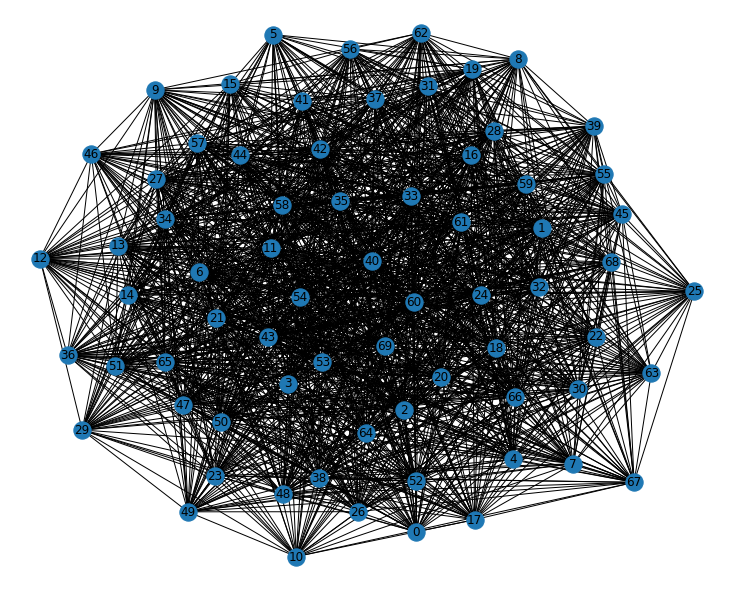

In [6]:
plt.figure(figsize=(10,8))
nx.draw(G, nx.spring_layout(G), with_labels=True)
plt.draw()

In [7]:
grados = dict(nx.degree(G))
#print(grados)
hojas = []
grados=dict(nx.degree(G))
grados[2]
for a,b in grados.items():
    if b == 1:
        hojas.append(a)
print(hojas)

[]


## Análisis del grafo

In [8]:
n = len(G.nodes)                            # Número de nodos
V = G.nodes                                 # Conjunto de nodos
A = G.edges                                 # Conjunto de aristas
k = 9# Número de componentes conexas que se quieren encontrar
K = tuplelist(range(0, k))

## Master problem

<div class="alert alert-block alert-info">
<b>Parámetros  de entrada y de salida de la función: Patron_Inicial</b>
    
<i>Datos de entrada</i>
1. $G\qquad$           es el grafo del problema,
2. $V\qquad$           conjunto de nodos del grafo
3. $k\qquad\,$         número de componentes conexas que se quieren encontrar.

<i>Datos de salida</i>
1. $F\qquad$   es el patrón inicial, el cual es una solución factible.
</div>

In [9]:
γ =2                                   # Número mínimo de nodos en un subgrafo

In [10]:
def neighbors(G, C):
    N = set()
    for i in C:
        N |= set(nx.neighbors(G,i))
    N = N - C
    return list(N)

def Arcos_Entrantes(A, i):
    entrantes = {i : [(j,k) for (j,k) in A if k==i]+[(j,k) for (k,j) in A if k==i]}
    return entrantes[i]

def Arcos_Corte_W(A, V, W):
    y1=[];
    y=[];
    y2=[]
    for i in W:
        y1=Arcos_Entrantes(A,i)
        for j in W:
            for (a,b) in y1:
                if (a,b)==(j,i):
                    y1.pop(y1.index((j,i)));   
        y=y+y1
    y=sorted(y);
    for i,j in y:
        if i<j:
            y2.append((i,j))
        else:
            y2.append((j,i))
    return y2;

def Patron_Inicial(G, V, k, γ):
    F = {};    Q = list(V)
    for c in range(k-1):
        i = Q.pop(0)
        C = {i}
        A = G.edges()
        while (len(C) < γ):
            #N  = neighbors(G.subgraph(V), C)
            aristas = Arcos_Corte_W(A, V, C)
            pesos = {}
            for e in aristas:
                pesos[e]=(d[e])
            #"s" es la arista de menor costo "c_e"
            s, c_e = min(pesos.items(), key = lambda x: x[1]) 
            if s[0] in C:
                i = s[1]
            else:
                i = s[0]       
            Q.remove(i)
            C |= {i} 
        F[c] = sorted(C)
        G = G.subgraph(set(V)-C)
        V = G.nodes()
    # crear la ultima componente conexa
    if ( nx.is_connected(G.subgraph(V) )):
        F[k-1] = sorted(set(V))
        print("Esta partición es factible.")
        return True, F
    else:
        return False, None

In [23]:
ι, F = Patron_Inicial(G, V, k, 8)
print(F)

Esta partición es factible.
{0: [0, 4, 19, 21, 24, 26, 27, 38], 1: [1, 2, 5, 8, 10, 18, 33, 34], 2: [3, 11, 12, 17, 23, 31, 35, 36], 3: [6, 9, 15, 20, 22, 28, 37, 40], 4: [7, 14, 16, 25, 30, 32, 41, 42], 5: [13, 39, 44, 45, 53, 55, 56, 63], 6: [29, 46, 47, 49, 51, 52, 58, 59], 7: [43, 48, 50, 57, 61, 62, 65, 69], 8: [54, 60, 64, 66, 67, 68]}


In [24]:
F={0: [0, 4, 21, 38], 1: [1, 2, 18, 27], 2: [3, 11, 17, 36], 3: [5, 6, 8, 10], 4: [7, 16, 25, 32], 5: [9, 30, 34, 42], 6: [12, 20, 35, 40], 7: [13, 22, 28, 37], 8: [14, 15, 19, 23, 24, 26, 29, 31, 33, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], 9: [0, 4, 19, 21, 38], 10: [1, 2, 18, 27, 32], 11: [3, 11, 12, 17, 36], 12: [5, 6, 8, 9, 10], 13: [7, 16, 25, 35, 41], 14: [13, 15, 22, 28, 37], 15: [14, 30, 33, 34, 61], 16: [20, 39, 40, 47, 50], 17: [23, 24, 26, 29, 31, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69], 18: [0, 4, 19, 21, 24, 38], 19: [1, 2, 16, 18, 27, 32], 20: [3, 11, 12, 17, 23, 36], 21: [5, 6, 8, 9, 10, 14], 22: [7, 25, 39, 40, 54, 55], 23: [13, 15, 22, 28, 37, 44], 24: [20, 31, 46, 47, 51, 58], 25: [26, 33, 48, 52, 59, 60], 26: [29, 30, 34, 35, 41, 42, 43, 45, 49, 50, 53, 56, 57, 61, 62, 63, 64, 65, 66, 67, 68, 69], 27: [0, 4, 19, 21, 24, 26, 38], 28: [1, 2, 7, 16, 18, 27, 32], 29: [3, 11, 12, 17, 23, 31, 36], 30: [5, 6, 8, 9, 10, 14, 34], 31: [13, 15, 20, 22, 28, 37, 40], 32: [25, 30, 39, 53, 54, 55, 56], 33: [29, 46, 47, 49, 51, 58, 59], 34: [33, 35, 48, 52, 57, 60, 61], 35: [41, 42, 43, 44, 45, 50, 62, 63, 64, 65, 66, 67, 68, 69], 36: [0, 4, 19, 21, 24, 26, 27, 38], 37: [1, 2, 5, 8, 10, 18, 33, 34], 38: [3, 11, 12, 17, 23, 31, 35, 36], 39: [6, 9, 15, 20, 22, 28, 37, 40], 40: [7, 14, 16, 25, 30, 32, 41, 42], 41: [13, 39, 44, 45, 53, 55, 56, 63], 42: [29, 46, 47, 49, 51, 52, 58, 59], 43: [43, 48, 50, 57, 61, 62, 65, 69], 44: [54, 60, 64, 66, 67, 68]}

Ingresamos las aristas como componentes 

In [25]:
cont=len(F)
for (i,j) in d.keys():
    F[cont]=[i,j]
    cont+=1

Generamos componentes conexas de tamaño r que se agregan a F

In [26]:
r = 3
com=list(itertools.combinations(V, r))
for i in com:
    if nx.is_connected(G.subgraph(i))==True:
        F[cont]=sorted(i)
        cont+=1

Usamos mucho los siguientes objetos:

In [27]:
ℓ = len(F);    rf = range(ℓ)

Adicionalmente, creamos la matriz asociada a cada componente.

In [28]:
import scipy.sparse as sparse

In [29]:
A = sparse.lil_matrix( (n, ℓ), dtype=int) # change to csr for big matrices

In [30]:
for i,f in F.items():
    for v in f:
        A[v,i] = 1

In [31]:
A = A.tocsr()


Finalmente, armamos un diccionario asociado al costo de cada componente encontrada.

In [32]:
c = {f:sum([ G[a[0]][a[1]]['w'] for a in G.subgraph(F[f]).edges]) for f in rf}
print(c)

{0: 12, 1: 15, 2: 9, 3: 17, 4: 4, 5: 13, 6: 13, 7: 15, 8: 2181, ...
38635: 18, 38636: 5, 38637: 12, 38638: 9, 38639: 10, 38640: 12, 38641: 12, 38642: 13, 38643: 11}


Creamos la siguiente instancia:
\begin{align}
    \min& \sum_{f\in F} c_f x_f
    \\
    \text{sujeta a}\qquad\qquad\quad &
    \\
    \sum_{f\in F} a_{i,f} x_f &= 1  & \forall i \in V,
    \\
    \sum_{f\in F} x_f &= k,
    \\
    x_f &\in \{0,1\}  & \forall f\in F.
\end{align}

In [33]:
del m

In [34]:
# Modelo en Gurobi
m = Model()

Academic license - for non-commercial use only - expires 2022-04-07
Using license file C:\Users\academico\gurobi.lic


In [35]:
# Variables
X = {}                                                      # diccionario para la variable x
X = m.addVars( rf, vtype = 'B', name='X')

In [36]:
# Restricciones
for i in V:
    nom = 'R_in[' + str(i) + ']';    co = LinExpr();    co.addTerms(A[i,:].A.ravel(), (X[f] for f in rf) )
    m.addConstr(co >= 1, name = nom)
    
m.addConstr( X.sum() <= k, name = 'R_comp')
m.update()

In [37]:
# Objetivo
obj = LinExpr()
obj.addTerms( (c[f] for f in rf), (X[f] for f in rf) )
m.setObjective(obj, 1)

In [38]:
m.update();
#m.write("Problema_M2V1.lp")
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 71 rows, 38644 columns and 153291 nonzeros
Model fingerprint: 0xad122a19
Variable types: 0 continuous, 38644 integer (38644 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 2279.0000000
Presolve time: 0.08s
Presolved: 71 rows, 38644 columns, 153291 nonzeros
Variable types: 0 continuous, 38644 integer (38644 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00      0s
       1         72   2.2790000e+03   2.1039792e+01      0s
       2        178   2.2790000e+03   9.3306840e+01      0s
       3        256   2.2790000e+03   1.0317861e+02      0s
       4     

In [39]:
print('El mejor peso por el momento es ', int(obj.getValue()), '.', sep='')

El mejor peso por el momento es 664.


### Generación de Columnas

In [40]:
κ = ℓ                        # clave del diccionario F
n = len(V)                   # cantidad de nodos en el grafo
n_γ = n - γ*(k-1)            # cantidad máxima de nodos en un subgrafo
β = []                       # almacena los valores objetivo del modelo relajado

In [41]:
# esta función me sirve para obtener las componentes que da como resultado al resolver el problema de pricing
def Componentes(V,y):
    W=[]
    for i in V:
        if y[i].x==1:
            W.append(i)
    return W

# esta función retorna la clave de un diccionario cuyo valor es maximo 
def keywithmaxval(d):
    # creamos una lista de las claves del dicionario 
    k = list(d.keys())
    # creamos una lista de los valores del diccionario
    v = list(d.values())
    # retornamos la clave con el máximo valor
    return k[v.index(max(v))], max(v)

# esta función retorna la clave de un diccionario cuyo valor es mínimo
def keywithminval(d):
    # creamos una lista de las claves del dicionario 
    k = list(d.keys())
    # creamos una lista de los valores del diccionario
    v = list(d.values())
    # retornamos la clave con el mínimo valor y dicho valor mínimo
    return k[v.index(min(v))], min(v)

# esta función retorna los vecinos de un corte, donde C es un conjunto de nodos
def neighbors(G, C):
    N = set()
    for i in C:
        N |= set(nx.neighbors(G,i))
    N = N - C
    return list(N)


In [42]:
# con esta función ingreamos al modelo una columna
def Actualizar_modelo(m, V, κ, F, c):
    # actualizamos las variables del modelo
    #X.update(m.addVars( R_s, vtype = 'B', name='X'))    # Nuevas variables
    X[κ] = m.addVar(obj = c[κ], vtype = 'B', name="X[%d]"%κ)    # Nuevas variables
    m.update()
    # Valor objetivo
    #m.setAttr('obj', [X[r] for r in R_s], [P[r][2] for r in R_s])
    #obj += quicksum( P[r][2]*x[r] for r in R_s)
    #m.update()
    # Modificación de restricciones por nodos afectados
    sense, rhs = '=', 1.0
    # Añadimos solo variables que contengan el nodo mencionado
    for i in F[κ]:
        nom  = 'R_in[' + str(i) + ']'             # Name the constraint
        co   = m.getConstrByName(nom)             # Retrieve constraint
        lhs  = m.getRow(co)                       # Get info
        m.remove(co)                              # Remove constraint
        # Una vez recorridas todas las componentes, se actualiza la restricción
        lhs += X[κ]                       # Add new information
        m.addConstr(lhs, sense, rhs, nom)    # Add new constraint
    
    ## Número de componentes
    co   = m.getConstrByName('R_comp')
    lhs  = m.getRow(co)
    m.remove(co)                              # Remove constraint
    lhs += X[κ]                               # Add new information
    m.addConstr(lhs, sense, k, 'R_comp')      # Add new constraint
    m.update()
        
    return None

# Algoritmo sin memoria

Transformamos el grafo creado con la librería Networkxs a un grafo de igraph

In [43]:
# Create an undirected graph
g = Graph()
# Add n vertices
g.add_vertices(V)
# Add ids and labels to vertices
for i in range(len(g.vs)):
    g.vs[i]["id"]= i
    g.vs[i]["label"]= str(i)
# Add edges
A = G.edges()
g.add_edges(A)
# Add weights and edge labels
g.es['weight'] = W
g.es['label'] = W

In [44]:
# m: es el modelo entero
# G: es el grafo en neworkxs
# g: es el grafo en igraph
# V: nodos del grafo
# F: diccionario con las columnas del modelo
# n_γ es el maximo número de nodos que puede tener un subgrafo
# π, ρ son los precios sombra

def Heuristic_Pricing_Problem_1(G, g, V, F, n_γ, π, ρ):
    P = []
    NC = []
    for v in V:
        C = {v}
        while (len(C) <= n_γ - 1):
            # N es una lista con los vecinos de C
            N = nx.node_boundary(G, C)
            if N == set():
                break
            # almacenamos en un diccionario los costos reducidos asociados a cada vecino del corte C, 
            #donde la clave será el nodo vecino y el valor es el costo reducido r_c
            r_c_N = {}
            for i in N:
                # calculamos la suma de las distancias del subgrafo en G de C unión i
                c_f = sum(g.subgraph(C| {i}).es['weight'])
                # Reduced cost 
                r_c_N[i] = c_f - sum(π[e] for e in (C | {i})) - ρ
            # s representa el nodo con costo reducido mínimo r_c_s
            s, r_c_s = min(r_c_N.items(), key = lambda x: x[1]) 
            # Criterio de salida del while
            #if  r_c_s > 0 and len(C) >= γ:
             #   break 
            #else:
            C = C | {s}
            C_o = sorted(C)
            if C_o not in F.values():
                if (len(C) >= γ and C_o not in NC and r_c_s < 0):
                    NC.append(C_o)
                    c_f = sum(g.subgraph(C).es['weight'])
                    P.append([C_o, r_c_s, c_f])
    return P

In [45]:
δ = 30          # cantidad de columnas que ingresan en una ronda de generación de columnas

In [46]:
inicio = time.time()
out    = 0
# Calculamos los precios sombra
r = m.relax();    r.Params.OutputFlag = False;   r.update(); r.optimize()
π  = {i: r.getConstrByName('R_in[' + str(i) + ']').Pi for i in V}
ρ  = r.getConstrByName('R_comp').Pi
β.append(r.ObjVal)
cont = 0
while(out == 0):
    P = Heuristic_Pricing_Problem_1(G, g, V, F, n_γ, π, ρ)
    P = sorted(P, key=lambda P: P[1])   # sort by reduced cost
    if P == []:
        break
    
    for componente, r_c, c_f in P[0:δ]:
        F[κ] = componente
        c[κ] = c_f
        Actualizar_modelo(m, V, κ, F, c)
        κ   += 1
    # Calculamos los precios sombra
    r = m.relax();    r.Params.OutputFlag = False;   r.update(); r.optimize()
    π  = {i: r.getConstrByName('R_in[' + str(i) + ']').Pi for i in V}
    ρ  = r.getConstrByName('R_comp').Pi
    β.append(r.ObjVal)
    
fin=time.time()
print("El tiempo que tarda en generar todas las columnas es: ", fin-inicio)

<ipython-input-46-8808b665acb5>:18: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  Actualizar_modelo(m, V, κ, F, c)


El tiempo que tarda en generar todas las columnas es:  458.1893482208252


## Resolvemos el modelo entero sin cortes

In [47]:
m.reset()
m.Params.Cuts = 0
m.Params.TimeLimit = 60*60
m.optimize()

print("\n")
print("La cantidad de columnas en el modelo es:", len(F))
print("El tiempo que tarda en generar todas las columnas es: ", fin-inicio)
print("El valor objetivo de la relajación lineal es: ", β[-1])
print("El valor objetivo del modelo entero es: ",m.ObjVal)
print("TIEMPO IP", m.Runtime )
print("\n")
# Extraemos las componentes en F
import re
cols=[]
for v in m.getVars():
    if v.x > 1e-5:
        s=str(v.varName)
        col=[int(s) for s in re.findall(r'\b\d+\b', s)]
        cols.append(col.pop())
print("Estas son las columnas de la solución óptima en F:", cols)

#verificamos si la k-particion tiene k componentes conexas
num_comp=0
for i in cols:
    if nx.is_connected(G.subgraph(F[i]))==True:
        print("F[%g]= " %num_comp ,F[i])
        num_comp+=1
if num_comp == k:
    print("Existen %g compoenetes conexas" %k)
    print("El valor Objetivo es:", m.ObjVal)
else:
    print("Existen mas de %g componentes conexas" %k)
    


Discarded solution information
Changed value of parameter Cuts to 0
   Prev: -1  Min: -1  Max: 3  Default: -1
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Consider calling update less frequently.

Optimize a model with 71 rows, 39640 columns and 163692 nonzeros
Model fingerprint: 0x58096e6c
Variable types: 0 continuous, 39640 integer (39640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 2279.0000000
Presolve time: 0.16s
Presolved: 71 rows, 39640 columns, 162032 nonzeros
Variable types: 0 continuous, 39640 integer (39640 binary)

Root relaxation: objective 1.458534e+02, 559 iterations, 0.20 seconds

    Nodes    |    Current Node    |     Objective Boun

## CORTES

$\alpha$ y $\beta$ son notaciones del artículo, en este cuadernillo $\gamma=\alpha$ y $n\_\gamma = \beta$

<div class="alert alert-block alert-info">
<b>Restricción de corte teorema 12</b>
    
Para todo $l$ entero, $\lceil \frac{n}{k}\rceil \leq l \leq \beta$
</div>

$$
\sum_{i=l}^{\beta}\sum_{f\in H(i)} x_f\leq \Big\lfloor\frac{n-k\alpha}{l-\alpha}\Big\rfloor 
$$

In [48]:
# Estblecemos el valor de l
l=math.ceil(n/k)
L = tuplelist(range(l,n_γ+1))
print("l=",l)
print("β=",n_γ)

#esta función retorna los indices de los subgrafos conexos de tamaño l hasta 𝛽=n_γ
def indice(F, ell, n_γ):
    H={r:[] for r in range(ell,n_γ+1)}
    for i,f in F.items():
        length = len(f)
        if ell <= length <= n_γ:
            H[length].append(i)
    return H

H = indice(F, l, n_γ)
# Restricción de corte teorema 12

start = time.time() 
cont1 = 1
for ell in L:
    rc2_name = "Res_corte_" + str(cont1)
    lhs = quicksum(quicksum(X[f] for f in H[i]) for i in range(ell,n_γ+1))
    if lhs.size() != 0:
        m.addConstr( lhs <= math.floor((n-k*γ)/(ell-γ)), name = rc2_name)
        cont1 += 1
end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

l= 8
β= 54
El tiempo que toma crear estas restricciones son: 0.0


In [49]:
L

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]

<div class="alert alert-block alert-info">
<b>Restricción de corte teorema 13</b>
    
Sea $\ell$ un entero, $\alpha \leq \ell \leq \beta$, $S\subset V$ con $|S|\geq \ell$ y $\theta=\Big\lfloor\frac{|S|}{\ell}\Big\rfloor$
</div>

$$
\sum_{i=l}^{\beta}\sum_{f\in \mathcal{F(S)}:\;|f|=i} x_f\leq \min\{k-1,\theta\} 
$$

In [50]:
# supongamos que ℓ=2 y |S|=4 y 5 

# Buscamos en F todas las componentes conexas de tamaño 2, 3, y 4
# almacenamos las componentes conexas en un diccionario según su tamaño: 2, 3, ó 4
#F_S={r:[] for r in range(5,7)}
#for i,f in F.items():
 #   length = len(f)
  #  if 5 <= length <= 6:
   #     F_S[length].append(f)
#print("la cantidad de componentes conexas de tamaño 4 y 5 es:",len(F_S[5])+len(F_S[6]))

# otra forma de obtener los índices de las componentes:
#list(F.values()).index(componente) # ya que su índice es la posición 


               
#x_frac = {(f):0.0 for f in range(len(F))}
#corte_S=0

#def mycallbacks(model, where):
 #   if where == GRB.Callback.MIPNODE:
  #      status = model.cbGet(GRB.Callback.MIPNODE_STATUS)
   #     if  status == GRB.OPTIMAL:
    #        for f in range(len(F)):
     #           x_frac[f] = model.cbGetNodeRel(X[f]) 
                
            #Buscamos en F la subfamilia de componentes conexas en (S, E(S))
      #      for card_S, S in F_S.items(): 
       #         for s in S:
        #            SS = []
         #           for r in range(2,card_S+1):
          #              com=list(itertools.combinations(s, r))
           #             for i in com:
            #                if sorted(i) in F.values(): # si está en F significa que es conexa
             #                   SS.append(list(F.values()).index(sorted(i))) 
                    #print(SS)
                    #minimo = min(k-1,math.floor(card_S/2))
                    #print(minimo)
                    #if sum(x_frac[f] for f in SS) > minimo:
                     #   corte_S+=1
                      #  model.cbCut(quicksum(X[f] for f in SS) <= minimo) 
                

## Resolvemos el modelo entero con cortes

In [51]:
m.Params.PreCrush = 1
m.Params.Cuts = 0
m.Params.TimeLimit = 60*60
m.reset()
m.optimize()
print("\n")
print("La cantidad de columnas en el modelo es:", len(F))
print("El tiempo que tarda en generar todas las columnas es: ", fin-inicio)
print("El valor objetivo de la relajación lineal es: ", β[-1])
print("El valor objetivo del modelo entero es: ",m.ObjVal)
print("TIEMPO IP", m.Runtime )
print("La cantidad de cortes en el nodo raíz es:", cont1-1)
print("\n")
# Extraemos las componentes en F
import re
cols=[]
for v in m.getVars():
    if v.x > 1e-5:
        s=str(v.varName)
        col=[int(s) for s in re.findall(r'\b\d+\b', s)]
        cols.append(col.pop())
print("Estas son las columnas de la solución óptima en F:", cols)

#verificamos si la k-particion tiene k componentes conexas
num_comp=0
for i in cols:
    if nx.is_connected(G.subgraph(F[i]))==True:
        print("F[%g]= " %num_comp ,F[i])
        num_comp+=1
if num_comp == k:
    print("Existen %g compoenetes conexas" %k)
    print("El valor Objetivo es:", m.ObjVal)
else:
    print("Existen mas de %g componentes conexas" %k)
    


Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Parameter Cuts unchanged
   Value: 0  Min: -1  Max: 3  Default: -1
Parameter TimeLimit unchanged
   Value: 3600.0  Min: 0.0  Max: inf  Default: inf
Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 102 rows, 39640 columns and 166285 nonzeros
Model fingerprint: 0xed646d6a
Variable types: 0 continuous, 39640 integer (39640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 2279.0000000
Presolve removed 24 rows and 0 columns
Presolve time: 0.26s
Presolved: 78 rows, 39640 columns, 164038 nonzeros
Variable types: 0 continuous, 39640 integer (39640 binary)

Root relaxation: objective 1.458534e+02, 478 iterations, 0.16 seconds

  

 55168  5362     cutoff   31       294.00000  220.71905  24.9%  52.6  486s
 56610  5245  245.99555   25   66  294.00000  222.02169  24.5%  52.5  492s
 57944  5118  252.89423   29   66  294.00000  223.31142  24.0%  52.3  497s
 59306  4982     cutoff   29       294.00000  224.95445  23.5%  52.2  502s
 60659  4789     cutoff   30       294.00000  226.47073  23.0%  52.0  507s
 62112  4576     cutoff   26       294.00000  228.60715  22.2%  51.8  512s
 63620  4332     cutoff   28       294.00000  230.61732  21.6%  51.6  517s
 65071  4044  239.78147   26   55  294.00000  232.12048  21.0%  51.3  522s
 66748  3745     cutoff   32       294.00000  234.87863  20.1%  51.1  526s
 68199  3443  245.18054   25   66  294.00000  237.43951  19.2%  50.9  531s
 69626  3141  283.12022   30   58  294.00000  239.84209  18.4%  50.6  535s
 71217  2651     cutoff   31       294.00000  243.01176  17.3%  50.4  540s
 73965  1636     cutoff   27       294.00000  251.41432  14.5%  49.9  546s
*74339    63             

In [ ]:
# Linearization CG plot
plt.figure(figsize=(20,6))
plt.title('Evolución de la relajación lineal en las rondas de generación de columnas\n'\
          + 'Estado actual: ' + str(β[-1]),fontsize=16)
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.plot(arange(0, len(β)), β,color='orange')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlim(-1, len(β)+5)
plt.ylabel('VO. Problema Relajado',fontsize=16)
plt.xlabel('Iteraciones',fontsize=18)
plt.show()

In [ ]:
len(β)